# <center> Assignment 2 - Computer Vision ENCS5343


### This assignment achieve to implement Content-Based Image Retrieval (CBIR) using various image representations in order to compare between them, observe the results of each method, measure the efficiency of each method using metrics (Accuracy, AUC, F1-Score, ....)
#### Steps: 
1. Data processing (uploading images and getting them ready).
2. Choose an image representation technique.
3. Apply the CBIR on 15 different queries.
4. Observe the results depending with their rankings.
5. Measure the preformace using different measure metrics.

### Step 0: Import important packages and libraries.

In [41]:
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
import time
from sklearn.metrics import auc, roc_curve

### Step 1: Upload and store the data.

In [3]:
def upload_and_store_images(dataset_filepath):
    images = []
    for filename in sorted(os.listdir(path=dataset_filepath)):
        image_path = os.path.join(dataset_filepath, filename)
        if os.path.isfile(image_path):
            try: 
                images.append(Image.open(image_path))
            except:
                print("Failed to upload image: {image_path}")
    return images
images = upload_and_store_images('./dataset')

In [4]:
images[0].height

384

### Step 2: Choose an image representation technique.

#### A. Color Histogram

In [9]:
def calculate_color_histogram(images, number_of_bins):
    color = ('b', 'g', 'r')
    histograms = []
    for i in range(len(images)):
        histograms.append([])
        total_pixels = images[i].height * images[i].width
        img = np.array(images[i])[:, :, ::-1].copy()
        for i in range(len(color)):
            histograms[-1].append(cv.calcHist([img], [i], None, [number_of_bins], [0,256]) / total_pixels)
    return np.array(histograms)
histograms_120 = calculate_color_histogram(images, 120)
histograms_180 = calculate_color_histogram(images, 180)
histograms_360 = calculate_color_histogram(images, 360)

#### Step 3 for Color Histogram: Apply CBIR on different random 15 query images

In [15]:
def calculate_distance(hist1, hist2):
    return np.linalg.norm(hist1 -hist2)

In [25]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [34]:
def distance_to_probability(distance):
    return np.exp(-distance)

def calculate_probabilities(index_query_image, images, histogram):
    probabilities = []
    for i, image in enumerate(images):
        distance = np.linalg.norm(histogram[index_query_image] - histogram[i])
        probabilities.append([image, distance_to_probability(distance), classes[i // 100]])
    probabilities.sort(key=lambda x: x[1], reverse=True)
    return probabilities


In [35]:
def retrieve_similar_images_using_hist(images, bins, threshold):
    global classes
    query_images_idxs = []
    query_images_classes = []
    query_images_similar_images = []
    query_images_similar_images_classes = []
    query_images_similar_images_probabilities = []
    for i in range(15):
        random_idx = np.random.randint(0, 1000)
        query_images_idxs.append(random_idx)
        query_images_classes.append(classes[random_idx // 100])
        probabilities = calculate_probabilities(random_idx, images, histogram=calculate_color_histogram(images, bins))
        query_images_similar_images.append([probability[0] for probability in probabilities if probability[1] >= threshold])
        query_images_similar_images_probabilities.append([probability[1] for probability in probabilities if probability[1] >= threshold])
        query_images_similar_images_classes.append([probability[2] for probability in probabilities if probability[1] >= threshold])
    return query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities

def compute_measures(query_image_class, retrieved_images_classes):
    true_positives = sum([1 for retrieved_image_class in retrieved_images_classes if retrieved_image_class == query_image_class])
    false_positives =  len(retrieved_images_classes) - true_positives
    false_negatives = 100 - true_positives
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 / (1 / recall + 1 / precision)
    return f1_score, precision, recall



F1-score for the 120-bins experiment: 0.19303414971400806
Recall score for the 120-bins experiment: 0.9006666666666665
Precision score for the 120-bins experiment: 0.11921726737599085
AUC for the 120-bins experiment: 0.5675301502019479
Time elapsed: 14.725713729858398


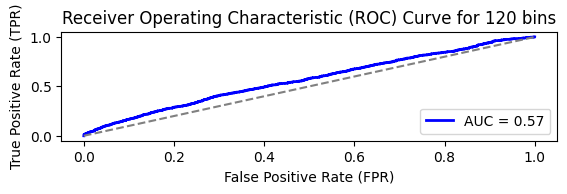

F1-score for the 180-bins experiment: 0.18048607560422597
Recall score for the 180-bins experiment: 0.9373333333333334
Precision score for the 180-bins experiment: 0.09985849659405469
AUC for the 180-bins experiment: 0.5647132441951521
Time elapsed: 13.133809566497803


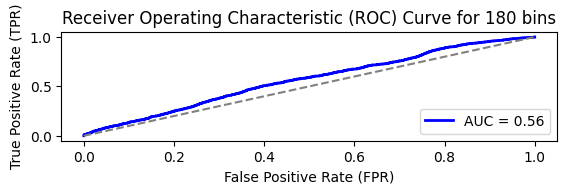

F1-score for the 360-bins experiment: 0.19415189638838193
Recall score for the 360-bins experiment: 0.9026666666666666
Precision score for the 360-bins experiment: 0.13022383215313654
AUC for the 360-bins experiment: 0.5512419109104698
Time elapsed: 13.615502834320068


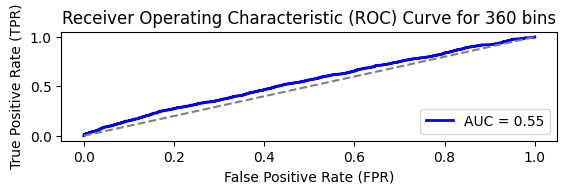

In [42]:

start_time_120_bins = time.time()
query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities = retrieve_similar_images_using_hist(images, bins=120, threshold=0.5)
f1_score_120 = 0
recall_120 = 0
precision_120 = 0 
true_labels = []
predicted_probs = []
for i in range(len(query_images_idxs)):
    f1_score_i, precision_i, recall_i = compute_measures(query_images_classes[i], query_images_similar_images_classes[i])
    f1_score_120 += f1_score_i / len(query_images_idxs)
    recall_120 += recall_i / len(query_images_idxs)
    precision_120 += precision_i / len(query_images_idxs)
    true_labels += [1 if label == query_images_classes[i] else 0 for label in query_images_similar_images_classes[i]]
    predicted_probs += query_images_similar_images_probabilities[i]

end_time_120_bins = time.time()
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
auc_measure_120 = auc(fpr, tpr)
print(f"F1-score for the 120-bins experiment: {f1_score_120}")
print(f"Recall score for the 120-bins experiment: {recall_120}")
print(f"Precision score for the 120-bins experiment: {precision_120}")
print(f"AUC for the 120-bins experiment: {auc_measure_120}")
print(f"Time elapsed: {end_time_120_bins - start_time_120_bins}")
plt.subplot(3, 1, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_measure_120:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for 120 bins')
plt.legend(loc='lower right')
plt.show()

start_time_180_bins = time.time()
query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities = retrieve_similar_images_using_hist(images, bins=180, threshold=0.5)
f1_score_180 = 0
recall_180 = 0
precision_180 = 0 
true_labels = []
predicted_probs = []
for i in range(len(query_images_idxs)):
    f1_score_i, precision_i, recall_i = compute_measures(query_images_classes[i], query_images_similar_images_classes[i])
    f1_score_180 += f1_score_i / len(query_images_idxs)
    recall_180 += recall_i / len(query_images_idxs)
    precision_180 += precision_i / len(query_images_idxs)
    true_labels += [1 if label == query_images_classes[i] else 0 for label in query_images_similar_images_classes[i]]
    predicted_probs += query_images_similar_images_probabilities[i]

end_time_180_bins = time.time()
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
auc_measure_180 = auc(fpr, tpr)

print(f"F1-score for the 180-bins experiment: {f1_score_180}")
print(f"Recall score for the 180-bins experiment: {recall_180}")
print(f"Precision score for the 180-bins experiment: {precision_180}")
print(f"AUC for the 180-bins experiment: {auc_measure_180}")
print(f"Time elapsed: {end_time_180_bins - start_time_180_bins}")
plt.subplot(3, 1, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_measure_180:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for 180 bins')
plt.legend(loc='lower right')
plt.show()

start_time_360_bins = time.time()
query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities = retrieve_similar_images_using_hist(images, bins=360, threshold=0.5)
f1_score_360 = 0
recall_360 = 0
precision_360 = 0 
true_labels = []
predicted_probs = []
for i in range(len(query_images_idxs)):
    f1_score_i, precision_i, recall_i = compute_measures(query_images_classes[i], query_images_similar_images_classes[i])
    f1_score_360 += f1_score_i / len(query_images_idxs)
    recall_360 += recall_i / len(query_images_idxs)
    precision_360 += precision_i / len(query_images_idxs)
    true_labels += [1 if label == query_images_classes[i] else 0 for label in query_images_similar_images_classes[i]]
    predicted_probs += query_images_similar_images_probabilities[i]

end_time_360_bins = time.time()
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
auc_measure_360 = auc(fpr, tpr)
print(f"F1-score for the 360-bins experiment: {f1_score_360}")
print(f"Recall score for the 360-bins experiment: {recall_360}")
print(f"Precision score for the 360-bins experiment: {precision_360}")
print(f"AUC for the 360-bins experiment: {auc_measure_360}")
print(f"Time elapsed: {end_time_360_bins - start_time_360_bins}")
plt.subplot(3, 1, 3)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_measure_360:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for 360 bins')
plt.legend(loc='lower right')
plt.show()
